# Wine Analysis


This Data was provided by the UCI Machine Learning Repository found here: https://archive.ics.uci.edu/ml/datasets/Wine

This data set has 14 attributes, which corresponds to 13 consistuents in each wine sample, and the class. In total there are 178 samples which are from one of three different cultivars, the data set is good for testing classifiers, however I chose to treat this data set as unclassified, and made the **goal of determining the class of each sample**. I decided to implement a **k-means unsupervised learning algorithm**, and afterwards I will compare the labels with the cluster each sample point was assigned to, and compare the accuracy. I follow this up by determining which attributes are the most important for classifying these wines, cheers!

The 13 consistuents in each wine sample are: alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavanoids, nonflavanoid phenols, proanthocryanins, color intensity, hue, OD280/OD315 of diluted wines, and proline.

In [7]:
import tensorflow as tf
import pandas as pd
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt
import random
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [52]:
data = np.loadtxt('wine.data', delimiter=',')
#get input and output of dataset
x = data[:,1:]
y= data[:,:1]

I normalize the data since we have different units of measurement for each attribute.

In [12]:
from sklearn import preprocessing

In [13]:
#I suppose this is fine for 13 attributes, but not very elegant
x_0 = preprocessing.normalize([x[:,0]]).flatten()
x_1 = preprocessing.normalize([x[:,1]]).flatten()
x_2 = preprocessing.normalize([x[:,2]]).flatten()
x_3 = preprocessing.normalize([x[:,3]]).flatten()
x_4 = preprocessing.normalize([x[:,4]]).flatten()
x_5 = preprocessing.normalize([x[:,5]]).flatten()
x_6 = preprocessing.normalize([x[:,6]]).flatten()
x_7 = preprocessing.normalize([x[:,7]]).flatten()
x_8 = preprocessing.normalize([x[:,8]]).flatten()
x_9 = preprocessing.normalize([x[:,9]]).flatten()
x_10 = preprocessing.normalize([x[:,10]]).flatten()
x_11 = preprocessing.normalize([x[:,11]]).flatten()
x_12 = preprocessing.normalize([x[:,12]]).flatten()

In [14]:
#preprocessing nromalizes along the rows
data_points = np.column_stack((x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11,x_12))

In [15]:
#function to update assignments for k-means clustering
def update_assignments(data, centroids):
    assignments = []
    #assign each point the index of the cluster who's centroid is closest
    for i in range(len(data)):
        assignments.append(np.argmin([np.linalg.norm(data[i]-c) for c in centroids]))
    return assignments

In [19]:
#function to update centroid of respective cluster in k-means clustering
def update_centroids(data, old_centroids, assignments):
    k = len(old_centroids)
    new_centroids = []
    #determine new centroid of each cluster
    for i in range(k):
        total_points = []
        #cluster points who's assignment corresponds to that cluster
        for j in range(len(assignments)):
            if assignments[j]==i:
                total_points.append(data[j])
        sum_total = np.zeros(len(data[0]))
        #find centroid of current cluster
        for m in range(len(total_points)):
            for n in range(len(data[0])):
                sum_total[n] += total_points[m][n]
        new_centroids.append([sum_total/len(total_points)])
    return new_centroids

I can choose the number of clusters for the algorithmn to be 3 since we know there are three different cultivars so I happen to know 3 clusters is a natural number of clusters for this data set but I will use a scree plot.

In [20]:
AvICD = []
for k in range(10):
    random_points_index = random.sample(range(len(data_points)), k+1)
    centroids = []
    for c in range(k+1):
        centroids.append(data_points[random_points_index[c]])
        #for each k value i let the centroids reach a more optimal position by allowing 5 sweeps
    for i in range(5):
        assignments = update_assignments(data_points, centroids)
        centroids = update_centroids(data_points, centroids, assignments)
    sum = 0
    counter = 0
    for n in range(k+1):
        for j in range(len(assignments)):
            if assignments[j]==n:
                counter +=1 
                sum += np.linalg.norm(data_points[j]-centroids[n])
    AvICD.append(sum/counter)

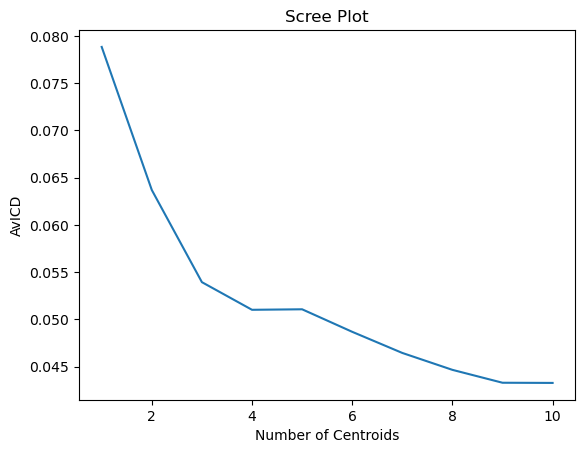

In [21]:
#plot the Scree plot
t = np.arange(10)+1
plt.plot(t, AvICD)
plt.xlabel('Number of Centroids')
plt.ylabel('AvICD')
plt.title('Scree Plot')
plt.show()

When there is more then three centroids we see the AcICD dramatically starts to plateau, this is a clear indication that the correct number of clusters for this data set is 3. This agrees with the known number of clusters, which corresponds to the number of cultivars.

Applying the k-means clustering with three clusters to the data set.

In [36]:
k = 3
#start centroids at random defined data_points (no duplicates)
random_points_index = random.sample(range(len(data_points)), k)
centroids = []
for i in range(k):
    centroids.append(data_points[random_points_index[i]])
assignments = []
#perform 10 full sweeps through all the points, updating assignments and centroids
for i in range(10):
    assignments = update_assignments(data_points, centroids)
    centroids = update_centroids(data_points, centroids, assignments)

Now to test the accuracy of using k-means on this dataset by comparing the assigned labels from the algorithm to the existing labels in the dataset

In [23]:
#change the corresponding number to the class so i can compare assigned labels
y[y==3]=0

In [24]:
miscount = 0
count_y = 0
count_assignments = 0
for i in range(len(y)):
    if y[i] != assignments[i]:
        miscount += 1
print("Number of miscounts: ", miscount)
print("Accuracy :", (len(y)-miscount)/len(y))

Number of miscounts:  13
Accuracy : 0.9269662921348315


So for the 178 data samples, the k-means algorithm applied to this dataset was able to successfully assign the correct class to 92.7 percent of samples, and only mislabelled 13 of the samples. Important to note, that the k-means algorithm chooses it's initial centroid positions at random, so the results may differ from one time of compiling to the next. I chose to perform 10 full sweeps through the points to ensure the correct final assignment were chosen for those initial centroids. 

Now I ask the question, how important are all 13 of these attributes for classification? Here I implement feature selection for machine learning, where I attempt to identify the attributes which contribute the most to the prediction of the model. The ultimate goal is determining which attributes are the most important for determining the class.

The following method for feature selection is the Recursive Feature Elimination (RFE) method, which works by removing attributes then building models on the attributes that remain, until the most influential attributes are determined in order. *The following block of code is based on the RFE method provided from the following link*: http://machinelearningmastery.com/feature-selection-machine-learning-python/

In [34]:
#Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#feature extraction
model = LogisticRegression(solver='liblinear')
rfe = RFE(model, n_features_to_select=2)
fit = rfe.fit(x, y.flatten())
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 2
Selected Features: [False False False False False False  True False False False  True False
 False]
Feature Ranking: [10  6  3  5 11  9  1  8  7  2  1  4 12]


This indicates that the top two contributin attributes correspond ot the 7th and 11th attributes. This is the attributes; Flavanoids, and Hue

Plotting only these two attributes along with their corresponding clas value yields the following plot:


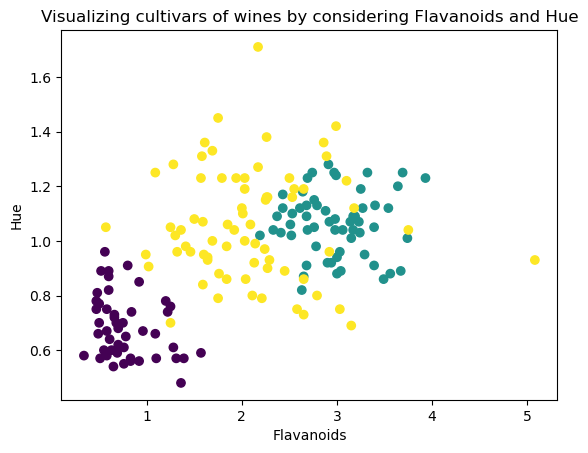

In [35]:
plt.scatter(x[:,6], x[:,10], c=y.flatten())
plt.xlabel('Flavanoids')
plt.ylabel('Hue')
plt.title('Visualizing cultivars of wines by considering Flavanoids and Hue')
plt.show()

There is some overlap between the cultivar corresponding to the yellow points, and the cultivar corresponding to the green points, but it's clear with only these two attributes I was able to still make distinctive clusters. Now time to perform the k-means clustering algorithm with just these two attributes determine the accuracy.

In [47]:
data_points2 = np.column_stack((x_6, x_10))
k = 3
#start centroids at random defined data_points (no duplicates)
random_points_index = random.sample(range(len(data_points2)), k)
centroids = []
for i in range(k):
    centroids.append(data_points2[random_points_index[i]])
assignments = []
#perform 10 full sweeps through all the points, updating assignments and centroids
for i in range(10):
    assignments = update_assignments(data_points2, centroids)
    centroids = update_centroids(data_points2, centroids, assignments)

In [54]:
#change the corresponding number to the class so i can compare the assigned labels
y[y==1]=0
y[y==3]=1

In [55]:
miscount = 0
count_y = 0
count_assignments = 0
for i in range(len(y)):
    if y[i] != assignments[i]:
        miscount += 1
print("Number of miscounts: ", miscount)
print("Accuracy :", (len(y)-miscount)/len(y))

Number of miscounts:  29
Accuracy : 0.8370786516853933


I managed to produce a accuracy of 83.7 percent for assigning the wines to the three cultivars with only 2 attributes as opposed to 92.7 percent with all 13 attributes. This is helpful depending on the size of the model, it may be advantageous to consider a small number of attributes in order to save on computational costs, or prioritization. 

The next most contributing attribute from our feature ranking determined before corresponds to the 10th attribute in the data set which is color intensity.

Below is a 3D plot of the top 3 feature attributes and the points are colour coordinated with respect to their cluster. 

In [56]:
from mpl_toolkits.mplot3d import Axes3D

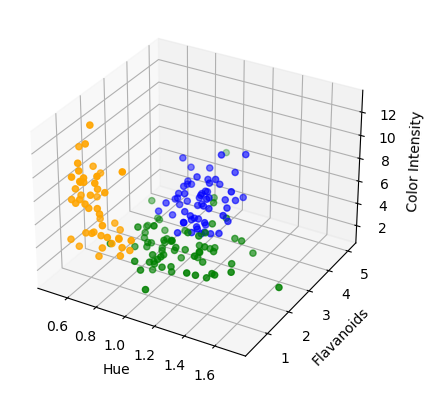

In [57]:
colours = np.array(["blue", "orange", "green"])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,10],x[:,6],x[:,9], c=colours[y.flatten().astype(int)])
ax.set_xlabel("Hue")
ax.set_ylabel("Flavanoids")
ax.set_zlabel("Color Intensity")
plt.show()

Aside from the boundary conditions, we can visually distinguish these three clusters quite well. I am going to check the accuracy of the k-means algorithm now that this one more attribute is being considered.

In [58]:
data_points3 = np.column_stack((x_10, x_6, x_9))
k = 3
#start centroids at random defined data_points (no duplicates)
random_points_index = random.sample(range(len(data_points3)), k)
centroids = []
for i in range(k):
    centroids.append(data_points3[random_points_index[i]])
assignments = []
#perform 10 full sweeps through all the points, updating assignments and centroids
for i in range(10):
    assignments = update_assignments(data_points3, centroids)
    centroids = update_centroids(data_points3, centroids, assignments)

In [61]:
#change the corresponding number to the class so i can compare the assigned labels
y[y==0]=4
y[y==2]=0
y[y==4]=2

In [62]:
miscount = 0
count_y = 0
count_assignments = 0
for i in range(len(y)):
    if y[i] != assignments[i]:
        miscount += 1
print("Number of miscounts: ", miscount)
print("Accuracy :", (len(y)-miscount)/len(y))

Number of miscounts:  21
Accuracy : 0.8820224719101124


This produced a accuracy of 88.2 percent for assigning the wines the three cultivars with only 3 attributes as opposed to 92.7 percent with all 13 attributes, and 83.7 percent with only 2 attributes. That is a significant increase, as the difference between 2 attributes and 13 attributes is 9 percent, and adding one more attribute accounted for 5.5 out of that 9 percent. 

As mentioned the three most important attributes for determing which wine came from which cultivar are; Flavanoids, Hue, and Color Intensity. It is interesting Hue and Color Intensity are both visual characteristics of the wine, and in this dataset; they are very importatnt for classifying the wine to it's respective cultivar. Considering this circumstance, a trained eye could actually determine which cultivar a wine came from with a fair amount of accuracy based on visual appearance alone, which is interesting!

Thanks for following along and reading this, I appreciate it!